# Task 3: Helper notebook for loading the data and saving the predictions

In [185]:
import pickle
import gzip
import numpy as np
import os

### Helper functions

In [186]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [187]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

### Load data, make predictions and save prediction in correct format

In [188]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
#samples = load_zipped_pickle("sample.pkl")

In [189]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def preprocess_train_data(data):
    video_frames = []
    mask_frames = []
    names = []
    for item in tqdm(data):
        video = item['video']
        name = item['name']
        height, width, n_frames = video.shape
        mask = np.zeros((height, width, n_frames), dtype=bool)
        for frame in item['frames']:
            mask[:, :, frame] = item['label'][:, :, frame]
            video_frame = video[:, :, frame]
            mask_frame = mask[:, :, frame]
            video_frame = np.expand_dims(video_frame, axis=2).astype(np.float32)
            mask_frame = np.expand_dims(mask_frame, axis=2).astype(np.int32)
            video_frames.append(video_frame)
            mask_frames.append(mask_frame)
            names.append(name)
    return names, video_frames, mask_frames

def preprocess_test_data(data):
    video_frames = []
    names = []
    for item in tqdm(data):
        video = item['video']
        video = video.astype(np.float32).transpose((2, 0, 1))
        video = np.expand_dims(video, axis=3)
        video_frames += list(video)
        names += [item['name'] for _ in video]
    return names, video_frames

In [9]:
names, videos, masks = preprocess_train_data(train_data)
test_names, test_videos = preprocess_test_data(test_data)

100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


### Extract Data grouped by video

In [217]:
def preprocess_train_data_grouped(data):
    video_data = {}
    mask_data = {}
    box_data = {}
    expert_data = {}
    names = []
    for item in tqdm(data):
        video = item['video']
        name = item['name']
        box = item['box']
        expert = item['dataset']
        names.append(name)
        height, width, n_frames = video.shape
        
        if name not in video_data:
            video_data[name] = []
            mask_data[name] = []
            #box_data[name] = []
            expert_data[name] = []
        
        box_data[name]=box
        expert_data[name].append(expert)
        mask = np.zeros((height, width, n_frames), dtype=bool)
        
        for frame in item['frames']:
            mask[:, :, frame] = item['label'][:, :, frame]
            
            video_frame = video[:, :, frame]
            mask_frame = mask[:, :, frame]
            
            video_frame = np.expand_dims(video_frame, axis=2).astype(np.float32)
            mask_frame = np.expand_dims(mask_frame, axis=2).astype(np.int32)
            
            video_data[name].append(video_frame)
            mask_data[name].append(mask_frame)
    
    return video_data, mask_data, names, box_data, expert_data

def preprocess_test_data_grouped(data):
    video_data = {}
    names = []
    for item in tqdm(data):
        video = item['video']
        name = item['name']
        names.append(name)
        
        if name not in video_data:
            video_data[name] = []
        
        video = video.astype(np.float32).transpose((2, 0, 1))  # Convert to (frames, height, width)
        video = np.expand_dims(video, axis=3)  # Add channel dimension
        
        video_data[name] += list(video)
    
    return video_data, names

In [232]:
videos, masks, names, box_data, expert_data = preprocess_train_data_grouped(train_data)
test_videos, test_names = preprocess_test_data_grouped(test_data)

100%|██████████| 20/20 [00:04<00:00,  4.81it/s]


### Visualize data to better understand the problem

In [233]:
def visualize_data(frame_idx, name, videos, masks, box):
    video_frames = videos[name]
    mask_frame = None
    box_vis = None
    if masks is not None:
        mask_frames = masks[name]
        mask_frame = mask_frames[frame_idx][:, :, 0]
        print(len(mask_frames))
        print(mask_frame.shape)
        
    if box is not None:
        box_vis = box[name]
        print(box_vis.shape)
        print(len(box))
    
    print(len(video_frames))
    
    
    video_frame = video_frames[frame_idx][:, :, 0]
    
    
    print(video_frame.shape)
    
    
    plt.figure(figsize=(12, 6))
    
    # Video frame
    plt.subplot(1, 3, 1)
    plt.title("Video Frame")
    plt.imshow(video_frame, cmap='gray')
    if box_vis is not None:
        plt.contour(box_vis, colors='r', levels=[0.5], linewidths=2)
    plt.axis('off')
    
    # Mask
    if mask_frame is not None:
        plt.subplot(1, 3, 2)
        plt.title("Mask Frame")
        plt.imshow(mask_frame, cmap='gray')
        plt.axis('off')
    
    
    plt.show()


3
(112, 112)
(112, 112)
65
3
(112, 112)


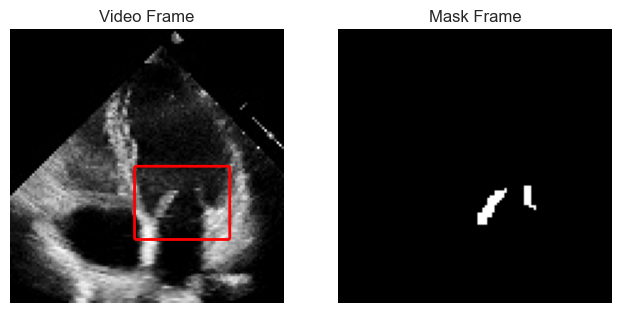

In [234]:
visualize_data(1, names[32], videos, masks, box_data)

### Rescale all of the images to 256x256 so that they can be fed into the model

In [235]:
import cv2
def resize_video_and_mask(video, mask, target_size=(256, 256)):
    """
    Resizes a single video and mask to the target size (upscaling or downscaling).

    Parameters:
        video (np.ndarray): Video array of shape (h, w, c).
        mask (np.ndarray): Mask array of shape (h, w, c).
        target_size (tuple): Target size (height, width).

    Returns:
        resized_video (np.ndarray): Resized video array of shape (target_size[0], target_size[1], c).
        resized_mask (np.ndarray): Resized mask array of shape (target_size[0], target_size[1], c).
        original_shapes (tuple): Original dimensions (height, width) for video and mask.
    """
    h, w, c = video.shape

    # Store original dimensions
    original_shapes = (h, w)

    # Resize video
    resized_video = np.stack(
        [cv2.resize(video[:, :, channel], target_size, interpolation=cv2.INTER_LINEAR)
         for channel in range(c)], axis=-1
    )
    
    # Resize mask
    resized_mask = np.stack(
        [cv2.resize(mask[:, :, channel], target_size, interpolation=cv2.INTER_NEAREST)
         for channel in range(c)], axis=-1
    )

    return resized_video, resized_mask, original_shapes

In [236]:
def resize_box(box, target_size=(256, 256)):
    """
    Resizes a box to the target size (upscaling or downscaling).

    Parameters:
        box (np.ndarray): Box array of shape (c, h, w).
        target_size (tuple): Target size (height, width).

    Returns:
        resized_box (np.ndarray): Resized box array of shape (c, target_size[0], target_size[1]).
        original_shapes (tuple): Original dimensions (height, width) for the box.
    """
    
    box = box.astype(np.uint8)
    # Resize each channel of the box
    resized_box = cv2.resize(box, target_size, interpolation=cv2.INTER_NEAREST)
    
    
    resized_box = resized_box.astype(bool)
    
    return resized_box

In [229]:
def rescale_video_and_mask(video, mask, original_shapes):
    """
    Rescales a single video and mask back to their original dimensions.

    Parameters:
        video (np.ndarray): Resized video array of shape (h, w, c).
        mask (np.ndarray): Resized mask array of shape (h, w, c).
        original_shapes (tuple): Original dimensions (height, width).

    Returns:
        rescaled_video (np.ndarray): Rescaled video array of shape (original_h, original_w, c).
        rescaled_mask (np.ndarray): Rescaled mask array of shape (original_h, original_w, c).
    """
    original_h, original_w = original_shapes
    c = video.shape[-1]

    # Resize video back to original dimensions
    rescaled_video = np.stack(
        [cv2.resize(video[:, :, channel], (original_w, original_h), interpolation=cv2.INTER_LINEAR)
         for channel in range(c)], axis=-1
    )

    # Resize mask back to original dimensions
    rescaled_mask = np.stack(
        [cv2.resize(mask[:, :, channel], (original_w, original_h), interpolation=cv2.INTER_NEAREST)
         for channel in range(c)], axis=-1
    )

    return rescaled_video, rescaled_mask

### The code below is used to rescale all of the images, boxes and masks to 256x256

In [237]:
original_shapes = {}

for name in names:
    if name not in original_shapes:
        original_shapes[name] = []
    for frame in range(len(videos[name])):
        videos[name][frame], masks[name][frame], original_shape = resize_video_and_mask(videos[name][frame], masks[name][frame])
        original_shapes[name].append(original_shape)
    box_data[name] = resize_box(box_data[name])
    


3
(256, 256)
(256, 256)
65
3
(256, 256)


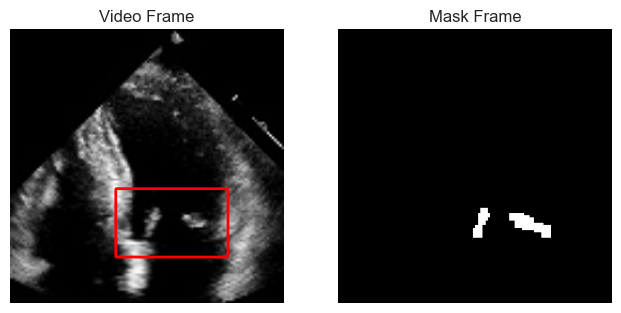

In [239]:
visualize_data(0, names[14], videos, masks, box_data)

### Make the dataset so that it is compatible with pytorch

In [241]:
from Make_Dataset import BoundingBoxDataset, MaskDataset
from make_transforms import get_transforms
from sklearn.model_selection import train_test_split

expert_patients = [name for name in expert_data if "expert" in expert_data[name]]
amateur_patients = [name for name in expert_data if "amateur" in expert_data[name]]

amateur_train, amateur_val = train_test_split(amateur_patients, test_size=0.2, random_state=42)
expert_train, expert_val = train_test_split(expert_patients, test_size=0.2, random_state=42)



train_transform = get_transforms(augment=True)
val_transform = get_transforms(augment=False)

bbox_amateur_train_dataset = BoundingBoxDataset(
    video_data={name: videos[name] for name in amateur_train},
    box_data={name: box_data[name] for name in amateur_train},
    transform=train_transform
)

segmentation_amateur_train_dataset = MaskDataset(
    video_data={name: videos[name] for name in amateur_train},
    mask_data={name: masks[name] for name in amateur_train},
    transform=train_transform
)

# Amateur validation dataset
bbox_amateur_val_dataset = BoundingBoxDataset(
    video_data={name: videos[name] for name in amateur_val},
    box_data={name: box_data[name] for name in amateur_val},
    transform=val_transform
)

segmentation_amateur_val_dataset = MaskDataset(
    video_data={name: videos[name] for name in amateur_val},
    mask_data={name: masks[name] for name in amateur_val},
    transform=val_transform
)




### Create the training loop for the model to predict the bounding boxes

### From the flattented array, retrieve indices and length for submission format

In [ ]:
def get_sequences(arr):
    first_indices, last_indices, lengths = [], [], []
    n, i = len(arr), 0
    arr = [0] + list(arr) + [0]
    for index, value in enumerate(arr[:-1]):
        if arr[index+1]-arr[index] == 1:
            first_indices.append(index)
        if arr[index+1]-arr[index] == -1:
            last_indices.append(index)
    lengths = list(np.array(last_indices)-np.array(first_indices))
    return first_indices, lengths

### Create .csv in submission format

In [ ]:
import pandas as pd

df = pd.DataFrame({"id":ids, "value":[list(map(int, minili)) for minili in values]})
df.to_csv(f"mysubmissionfile_{THRESHOLD}.csv", index=False)